In [2]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random

# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load Data

In [2]:
filename = 'Datasets/All_subjects_RDmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train1 = np.array(data["train_img"])
y_train1 = np.array(data["train_labels"])
x_test1 = np.array(data["test_img"])
y_test1 = np.array(data["test_labels"])
data.close()
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

Selected File: Datasets/All_subjects_RDmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [3]:
filename = 'Datasets/All_subjects_RAmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train2 = np.array(data["train_img"])
y_train2 = np.array(data["train_labels"])
x_test2 = np.array(data["test_img"])
y_test2 = np.array(data["test_labels"])
data.close()
print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

Selected File: Datasets/All_subjects_RAmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [4]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(x_train1[:,interval,:,:,:], (x_train1.shape[0],120,5,x_train1.shape[2],x_train1.shape[3],x_train1.shape[4]))
x_test11 = np.reshape(x_test1[:,interval,:,:,:], (x_test1.shape[0],120,5,x_test1.shape[2],x_test1.shape[3],x_test1.shape[4]))
y_train11 = np.reshape(np.argmax(y_train1[:,interval,:],-1), (y_train1.shape[0],120,5))
y_test11 = np.reshape(np.argmax(y_test1[:,interval,:],-1), (y_test1.shape[0],120,5))
y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
print(y_train11.shape)
print(x_test11.shape)
print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(x_train2[:,interval,:,:,:], (x_train2.shape[0],120,5,x_train2.shape[2],x_train2.shape[3],x_train2.shape[4]))
x_test12 = np.reshape(x_test2[:,interval,:,:,:], (x_test2.shape[0],120,5,x_test2.shape[2],x_test2.shape[3],x_test2.shape[4]))
y_train12 = np.reshape(np.argmax(y_train2[:,interval,:],-1), (y_train2.shape[0],120,5))
y_test12 = np.reshape(np.argmax(y_test2[:,interval,:],-1), (y_test2.shape[0],120,5))
y_train12 = to_categorical(np.squeeze(stats.mode(y_train12,2)[0]))
y_test12 = to_categorical(np.squeeze(stats.mode(y_test12,2)[0]))
print(x_train12.shape)
print(y_train12.shape)
print(x_test12.shape)
print(y_test12.shape) 

(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)
(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)


In [5]:
filename = 'Datasets/All_subjects_spectrogram.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train3 = np.array(data["train_img"])
y_train3 = np.array(data["train_labels"])
x_test3 = np.array(data["test_img"])
y_test3 = np.array(data["test_labels"])
data.close()
print(x_train3.shape)
print(y_train3.shape)
print(x_test3.shape)
print(y_test3.shape)

Selected File: Datasets/All_subjects_spectrogram.hdf5
(527, 120, 128, 128, 3)
(527, 120, 19)
(132, 120, 128, 128, 3)
(132, 120, 19)


In [6]:
filename = 'Datasets/All_subjects_margins_and_ctc_label_no_nucleus.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
margin_tr = np.array(data["train_img"])
ctc_tr = np.squeeze(np.array(data["train_labels"])).astype('U12')
margin_ts = np.array(data["test_img"])
ctc_ts = np.squeeze(np.array(data["test_labels"])).astype('U12')
data.close()
print(margin_tr.shape)
print(ctc_tr.shape)
print(margin_ts.shape)
print(ctc_ts.shape)

Selected File: Datasets/All_subjects_margins_and_ctc_label_no_nucleus.hdf5
(527, 1482)
(527,)
(132, 1482)
(132,)


In [7]:
filename = 'Datasets/All_subjects_spect_single.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train4 = np.array(data["train_img"])
x_test4 = np.array(data["test_img"])
data.close()
print(x_train4.shape)
print(x_test4.shape)

Selected File: Datasets/All_subjects_spect_single.hdf5
(527, 128, 128, 3)
(132, 128, 128, 3)


##### STA LTA

In [11]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

In [9]:
duration = 24.2
nsta_sec = 0.7
ratio = margin_tr.shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,margin_ts.shape[1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(margin_tr)):
    vecs_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(margin_ts)):
    vecs_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)

### Visualize

In [10]:
np.unique(np.argmax(y_test3[idx],-1))

array([0, 1, 2, 3, 4, 5, 6])

In [11]:
# downsample the mask to vid
mask_vid_tr = np.zeros(np.argmax(y_train1,-1).shape)
ratio1 = mask_train.shape[-1]/mask_vid_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_vid_tr[i,int(j/ratio1)] = 1
mask_vid_ts = np.zeros(np.argmax(y_test1,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_vid_ts[i,int(j/ratio1)] = 1

# downsample the mask to spect
mask_spect_tr = np.zeros(np.argmax(y_train3,-1).shape)
ratio2 = mask_train.shape[-1]/mask_spect_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_spect_tr[i,int(j/ratio2)] = 1
mask_spect_ts = np.zeros(np.argmax(y_test3,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_spect_ts[i,int(j/ratio2)] = 1
print('Mask shapes:')
print(mask_vid_tr.shape)
print(mask_vid_ts.shape)
print(mask_spect_tr.shape)
print(mask_spect_ts.shape)

Mask shapes:
(527, 605)
(132, 605)
(527, 120)
(132, 120)


In [12]:
def gesture_counter(mask):
    cnt = 0
    flag = 0
    for i in range(len(mask)):
        if flag == 0 and mask[i] == 0:
            continue
        if flag == 1 and mask[i] == 1:
            continue
        if flag == 0 and mask[i] == 1:
            flag = 1
            cnt += 1
        if flag == 1 and mask[i] == 0:
            flag = 0
    return cnt

In [54]:
numgest = [gesture_counter(m) for m in mask_spect_ts]
sum(numgest)

813

In [22]:
num_class = y_test3.shape[2]
num_class

19

In [3]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [16]:
x1train, y1train = masker(x_train11, y_train3, mask_spect_tr)
x1test, y1test = masker(x_test11, y_test3, mask_spect_ts)
x2train, y2train = masker(x_train12, y_train3, mask_spect_tr)
x2test, y2test = masker(x_test12, y_test3, mask_spect_ts)
x3train, y3train = masker(x_train3, y_train3, mask_spect_tr)
x3test, y3test = masker(x_test3, y_test3, mask_spect_ts)
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(y2train.shape)
print(x2test.shape)
print(y2test.shape)
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

/home/m/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(3042,)
(3042,)
(740,)
(740,)
(3042,)
(3042,)
(740,)
(740,)
(3042,)
(3042,)
(740,)
(740,)


In [56]:
x1test_nowin, y1test_nowin = masker(x_test1, y_test1, mask_vid_ts)
x2test_nowin, y2test_nowin = masker(x_test2, y_test2, mask_vid_ts)
print(x1test_nowin.shape)
print(y1test_nowin.shape)
print(x2test_nowin.shape)
print(y2test_nowin.shape)

(831,)
(831,)
(831,)
(831,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### No GD

In [21]:
def data_generator_nolabel(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
#             label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
#                 y_train.append(np.array([ord(y)%32 for y in label[i]]))

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
#             y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train

In [17]:
model_file = 'Models/td2d-bilstm 19 class NO GD fbf seq mD.json'
w_file = 'Models/td2d-bilstm 19 class NO GD fbf seq mD.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_nogd_md = model_from_json(loaded_model_json)
model_nogd_md.load_weights(w_file)

In [19]:
model_file = 'Models/td2d-bilstm 19 class NO GD fbf seq RD.json'
w_file = 'Models/td2d-bilstm 19 class NO GD fbf seq RD.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_nogd_rd = model_from_json(loaded_model_json)
model_nogd_rd.load_weights(w_file)

In [20]:
model_file = 'Models/td2d-bilstm 19 class NO GD fbf seq RA.json'
w_file = 'Models/td2d-bilstm 19 class NO GD fbf seq RA.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_nogd_ra = model_from_json(loaded_model_json)
model_nogd_ra.load_weights(w_file)

In [68]:
predict_generator = data_generator_nolabel(x2test_nowin)

In [63]:
pred = [np.argmax(np.squeeze(model_nogd_ra.predict(next(predict_generator))),-1) for i in range(len(x2test_nowin))]

In [64]:
# best path decoding
pred_labels = np.squeeze(np.array([stats.mode(p)[0] for p in pred]))

In [65]:
actuals = np.squeeze(np.array([stats.mode(np.argmax(y,-1))[0] for y in y2test_nowin]))

In [66]:
cmp = pred_labels == actuals
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

60.64981949458483

## Blake's Data

In [12]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [13]:
filename = 'Datasets/Blake_RDmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train1 = np.array(data["train_img"])
y_train1 = np.array(data["train_labels"])
x_test1 = np.array(data["test_img"])
y_test1 = np.array(data["test_labels"])
data.close()
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

Selected File: Datasets/Blake_RDmap.hdf5
(14, 750, 128, 128, 3)
(14, 750, 19)
(4, 750, 128, 128, 3)
(4, 750, 19)


In [14]:
filename = 'Datasets/Blake_RAmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train2 = np.array(data["train_img"])
y_train2 = np.array(data["train_labels"])
x_test2 = np.array(data["test_img"])
y_test2 = np.array(data["test_labels"])
data.close()
print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

Selected File: Datasets/Blake_RAmap.hdf5
(14, 750, 128, 128, 3)
(14, 750, 19)
(4, 750, 128, 128, 3)
(4, 750, 19)


In [15]:
# windowed RD
interval = range(0,750)
winlenx = 5
totallen = 150
x_train11 = np.reshape(x_train1[:,interval,:,:,:], (x_train1.shape[0],totallen,winlenx,x_train1.shape[2],x_train1.shape[3],x_train1.shape[4]))
x_test11 = np.reshape(x_test1[:,interval,:,:,:], (x_test1.shape[0],totallen,winlenx,x_test1.shape[2],x_test1.shape[3],x_test1.shape[4]))
y_train11 = np.reshape(np.argmax(y_train1[:,interval,:],-1), (y_train1.shape[0],totallen,winlenx))
y_test11 = np.reshape(np.argmax(y_test1[:,interval,:],-1), (y_test1.shape[0],totallen,winlenx))
y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
print(y_train11.shape)
print(x_test11.shape)
print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(x_train2[:,interval,:,:,:], (x_train2.shape[0],totallen,winlenx,x_train2.shape[2],x_train2.shape[3],x_train2.shape[4]))
x_test12 = np.reshape(x_test2[:,interval,:,:,:], (x_test2.shape[0],totallen,winlenx,x_test2.shape[2],x_test2.shape[3],x_test2.shape[4]))
y_train12 = np.reshape(np.argmax(y_train2[:,interval,:],-1), (y_train2.shape[0],totallen,winlenx))
y_test12 = np.reshape(np.argmax(y_test2[:,interval,:],-1), (y_test2.shape[0],totallen,winlenx))
y_train12 = to_categorical(np.squeeze(stats.mode(y_train12,2)[0]))
y_test12 = to_categorical(np.squeeze(stats.mode(y_test12,2)[0]))
print(x_train12.shape)
print(y_train12.shape)
print(x_test12.shape)
print(y_test12.shape) 

(14, 150, 5, 128, 128, 3)
(14, 150, 19)
(4, 150, 5, 128, 128, 3)
(4, 150, 19)
(14, 150, 5, 128, 128, 3)
(14, 150, 19)
(4, 150, 5, 128, 128, 3)
(4, 150, 19)


In [16]:
filename = 'Datasets/Blake_spectrogram.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train3 = np.array(data["train_img"])
y_train3 = np.array(data["train_labels"])
x_test3 = np.array(data["test_img"])
y_test3 = np.array(data["test_labels"])
data.close()
print(x_train3.shape)
print(y_train3.shape)
print(x_test3.shape)
print(y_test3.shape)

Selected File: Datasets/Blake_spectrogram.hdf5
(14, 150, 128, 128, 3)
(14, 150, 19)
(4, 150, 128, 128, 3)
(4, 150, 19)


In [17]:
filename = 'Datasets/Blake_margins_and_ctc_label_no_nucleus.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
margin_tr = np.array(data["train_img"])
ctc_tr = np.squeeze(np.array(data["train_labels"])).astype('U12')
margin_ts = np.array(data["test_img"])
ctc_ts = np.squeeze(np.array(data["test_labels"])).astype('U12')
data.close()
print(margin_tr.shape)
print(ctc_tr.shape)
print(margin_ts.shape)
print(ctc_ts.shape)

Selected File: Datasets/Blake_margins_and_ctc_label_no_nucleus.hdf5
(14,)
(14,)
(4,)
(4,)


In [18]:
duration = 30
nsta_sec = 0.7 # 0.7
ratio = margin_tr[0].shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,duration,margin_ts[0].shape[0])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(margin_tr)):
    vecs_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(margin_ts)):
    vecs_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)

In [19]:
# downsample the mask to vid
max_len = 1488
mask_vid_tr = np.zeros(np.argmax(y_train1,-1).shape)
ratio1 = mask_train[0].shape[-1]/mask_vid_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train[i].shape[-1]):
        if mask_train[i][j] == 0:
            continue
        else:
            mask_vid_tr[i,int(j/ratio1)] = 1
mask_vid_ts = np.zeros(np.argmax(y_test1,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test[i].shape[-1]):
        if mask_test[i][j] == 0:
            continue
        else:
            mask_vid_ts[i,int(j/ratio1)] = 1

# downsample the mask to spect
mask_spect_tr = np.zeros(np.argmax(y_train3,-1).shape)
ratio2 = mask_train[0].shape[-1]/mask_spect_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train[i].shape[-1]):
        if mask_train[i][j] == 0:
            continue
        else:
            mask_spect_tr[i,int(j/ratio2)] = 1
mask_spect_ts = np.zeros(np.argmax(y_test3,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test[i].shape[-1]):
        if mask_test[i][j] == 0:
            continue
        else:
            mask_spect_ts[i,int(j/ratio2)] = 1
print('Mask shapes:')
print(mask_vid_tr.shape)
print(mask_vid_ts.shape)
print(mask_spect_tr.shape)
print(mask_spect_ts.shape)

Mask shapes:
(14, 750)
(4, 750)
(14, 150)
(4, 150)


In [20]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [23]:
x1train, y1train = masker(x_train11, y_train3, mask_spect_tr)
x1test, y1test = masker(x_test11, y_test3, mask_spect_ts)
x2train, y2train = masker(x_train12, y_train3, mask_spect_tr)
x2test, y2test = masker(x_test12, y_test3, mask_spect_ts)
x3train, y3train = masker(x_train3, y_train3, mask_spect_tr)
x3test, y3test = masker(x_test3, y_test3, mask_spect_ts)
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(y2train.shape)
print(x2test.shape)
print(y2test.shape)
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

(123,)
(123,)
(32,)
(32,)
(123,)
(123,)
(32,)
(32,)
(123,)
(123,)
(32,)
(32,)


In [24]:
# merge all to test
x1test = np.concatenate([x1train,x1test],0)
print(x1test.shape)
x2test = np.concatenate([x2train,x2test],0)
print(x2test.shape)
x3test = np.concatenate([x3train,x3test],0)
print(x3test.shape)
y1test = np.concatenate([y1train,y1test],0)
print(y1test.shape)
y2test = np.concatenate([y2train,y2test],0)
print(y2test.shape)
y3test = np.concatenate([y3train,y3test],0)
print(y3test.shape)

(155,)
(155,)
(155,)
(155,)
(155,)
(155,)


Text(0, 0.5, 'Normalized Euclidean Distance')

/home/m/.local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


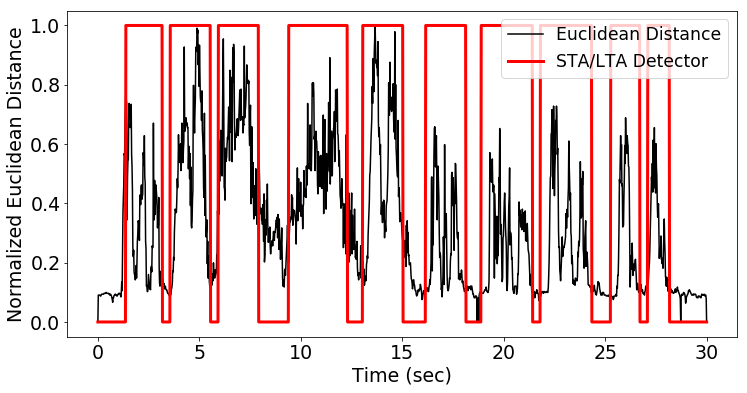

In [25]:
idx = 1
plt.plot(timevec,margin_tr[idx]/max(margin_tr[idx]),color='black')
plt.plot(timevec,mask_train[idx],linewidth=3,color='red')
plt.legend(['Euclidean Distance','STA/LTA Detector'], loc = 'upper right', fontsize = 'xx-large')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel('Time (sec)',fontsize=19, fontname='Comic Sans MS')
plt.ylabel('Normalized Euclidean Distance',fontsize=19)
# plt.savefig(str(idx)+' gesture detect.png',dpi=400)

In [26]:
def num_to_ch(num):
    label = ''
    for ch in num:
        label += chr(ord('@') + np.argmax(ch,-1)+1)
    return label

In [27]:
# convert detected labels
ctc_tr3 = [num_to_ch(y) for y in y3train]
ctc_ts3 = [num_to_ch(y) for y in y3test]

In [28]:
ctc_ts3

['OOOOOOOOOOOA',
 'AASSSSSSSS',
 'SSSSSSAA',
 'AAAFFFFFF',
 'FFFFFAAARRRRRRRRRR',
 'ARRRRRRRRRRR',
 'AALLLLLLLLLLLLLLAAA',
 'ASSSSSSS',
 'SSSSSAA',
 'RRRRRRRRRRR',
 'AADDDDDDDDDA',
 'BBBBBBBBBBBB',
 'BBBBBBBBBBBBBBBBB',
 'AACCCCCCCCCC',
 'AJJJJJJJJJJA',
 'AAAOOOOOOOOOOAA',
 'AARRRRRRRRRRRA',
 'AASSSSSSS',
 'SSSSSSSA',
 'AAAAAACCCCCCCCCC',
 'AHHHHHH',
 'HHHHHHARRRRRRRRR',
 'AAIIIIIIIIIIA',
 'AAKKKKKKKKKKKAA',
 'AARRRRRRRRR',
 'AAEEEEEEEE',
 'EEEEAA',
 'AJJJJJJJJJAA',
 'AARRRRRRRRRRRRAA',
 'GGGGGG',
 'GGGGGGA',
 'AJJJJJJJJJJJ',
 'AARRRRRRRRR',
 'AJJJJJJJJJJA',
 'AASSSSSSSSSSSSS',
 'AIIIIIIIIIIIIA',
 'AAQQQQQQQQQQQQQAA',
 'AAARRRRRRRRR',
 'BBBBBBBBBBBBBBBBBBBACCCCCCCCCCCC',
 'AJJJJJJJJJA',
 'AARRRRRRRRRRAA',
 'AAAKKKKKKKKKKA',
 'AAAQQQQQQQQQQQQAA',
 'AARRRRRRRRRR',
 'AASSSSSSSSSSSS',
 'KKKKKKKKKKKKK',
 'AOOOOOOOOOOOOOOA',
 'AARRRRRRRRR',
 'AAMMMMMMMMMMMA',
 'AAKKKKKKKKKKKA',
 'AOOOOOOOOOO',
 'ARRRRRRRRRR',
 'AEEEEEEEEEEEEAA',
 'RRRRRRRRRRR',
 'AGGGGGGG',
 'GGGGGGGAA',
 'AFFFFFFFFFFFFAAARR

In [29]:
def data_generator_multi_nolabel_rd(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [40]:
predict_generator = data_generator_multi_nolabel_rd([x1train, x2train, x3train])

In [41]:
fname = 'final2 multi ctc mtl gd'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path
json_file = open(MODEL_FILE, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_load = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_load.load_weights(WEIGHT_FILE)

In [42]:
prediction_model = keras.models.Model(
    [model_load.get_layer(name="rd").input, model_load.get_layer(name="ra").input, model_load.get_layer(name="image").input], model_load.get_layer(name="dense2").output
)

In [ ]:
probs = np.array([np.squeeze(prediction_model.predict(next(predict_generator))) for i in range(len(x3test))],dtype=object)
pred = np.array([np.argmax(probs[i],-1) for i in range(len(x3test))], dtype = object)

In [ ]:
pred_labels = []
pred_ch_ls = []
for p in pred:
    label = []
    for num in p:
        if num == 20:# or chr(ord('@')+num) == 'A':
            continue
        label.append(num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels,dtype=object)  
print(pred_labels[3])

In [ ]:
for idx in range(len(y3test)):
    print(str(idx+1) + '. Predicted: ' + str(pred_labels[idx]) + ' | ' + str(np.argmax(y3test[idx],-1)) + ' :Original')

In [ ]:
from collections import Counter
mode_orig = [max(Counter(np.argmax(y,-1)+1)) for y in y3test]
mode_pred = [max(Counter(y)) if len(y) != 0 else 1 for y in pred_labels]

In [ ]:
Counter(mode_orig)

In [ ]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(y3test))]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

/home/m/.local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<function matplotlib.pyplot.show(*args, **kw)>

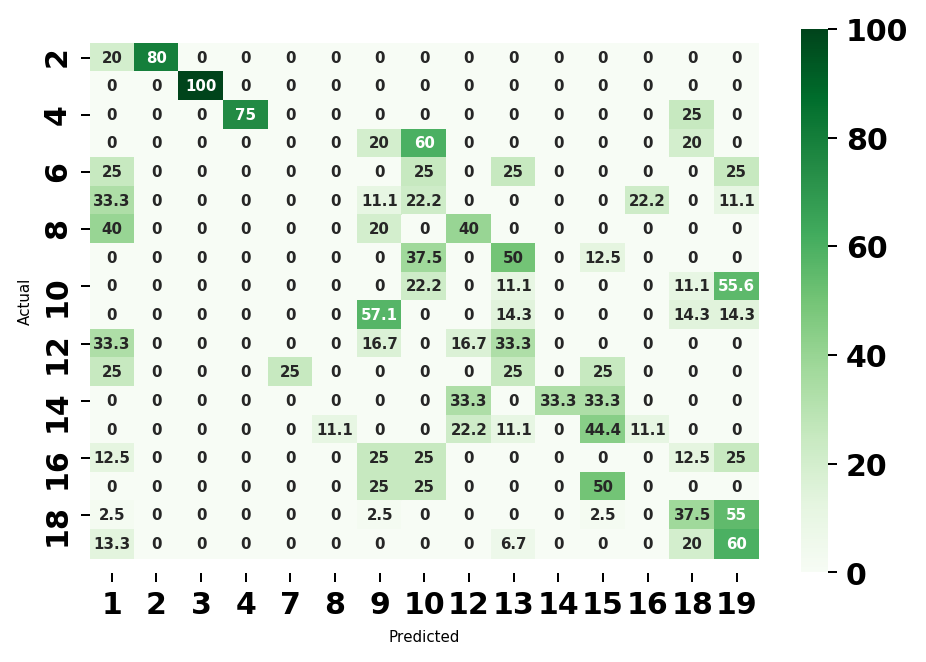

In [39]:
##### import pandas as pd
import seaborn as sn
font = {'family' : 'normal', 
        'weight' : 'bold',
        'size'   : 6}

plt.rc('font', **font) 
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12) 
Y_pred = np.array([y for y in mode_pred]) 
Y_test_int = np.array([y for y in mode_orig]) 
data = {'y_Predicted': Y_pred,
        'y_Actual':    Y_test_int
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], normalize='index', rownames=['Actual'], 
                               colnames=['Predicted'], margins = False)\
.round(3)*100
fig = plt.figure(dpi=180)
sn.heatmap(confusion_matrix,annot=True, cmap="Greens", fmt='g') # cbar_kws={'format': '%.0f%%'},
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
cap = plt.gcf()
plt.savefig('results/blake free multitask multi input ctc.png', dpi = 400)
plt.show

## mD model blake

In [43]:
model_file = 'Models/ctc aux multitask md 90-27.json'
w_file = 'Models/ctc aux multitask md 90-27.h5'
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_md = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_md.load_weights(w_file)

In [55]:
def data_generator_multi_nolabel_rd(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield X_train3

In [56]:
predict_generator_md = data_generator_multi_nolabel_rd([x1test, x2test, x3test])

In [57]:
x3test[0].shape

(12, 128, 128, 3)

In [61]:
prediction_model2 = keras.models.Model(
    [model_md.get_layer(name="image").input], model_md.get_layer(name="dense2").output
)

In [62]:
probs = np.array([np.squeeze(prediction_model2.predict(next(predict_generator_md))) for i in range(len(x3test))],dtype=object)
pred = np.array([np.argmax(probs[i],-1) for i in range(len(x3test))], dtype = object)

In [63]:
pred_labels = []

for p in pred:
    label = []
    for num in p:
        if num == 20:# or chr(ord('@')+num) == 'A':
            continue
        label.append(num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels,dtype=object)  
print(pred_labels[3])

[1, 11, 11, 11, 19, 11]


In [64]:
from collections import Counter
mode_orig = [max(Counter(np.argmax(y,-1)+1)) for y in y3test]
mode_pred = [max(Counter(y)) if len(y) != 0 else 1 for y in pred_labels]

In [65]:
Counter(mode_orig)

Counter({15: 9,
         19: 15,
         6: 8,
         18: 40,
         12: 6,
         4: 4,
         2: 5,
         3: 6,
         10: 9,
         8: 5,
         9: 8,
         11: 7,
         5: 5,
         7: 9,
         17: 4,
         13: 4,
         16: 8,
         14: 3})

In [66]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(y3test))]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

29.677419354838708

<function matplotlib.pyplot.show(*args, **kw)>

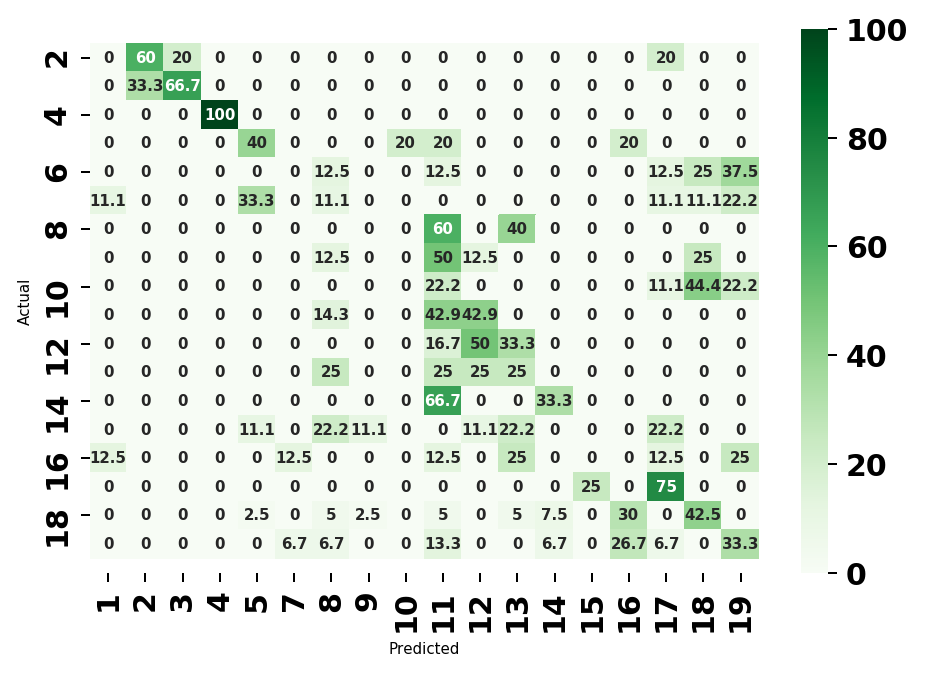

In [67]:
##### import pandas as pd
import seaborn as sn
font = {'family' : 'normal', 
        'weight' : 'bold',
        'size'   : 6}

plt.rc('font', **font) 
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12) 
Y_pred = np.array([y for y in mode_pred]) 
Y_test_int = np.array([y for y in mode_orig]) 
data = {'y_Predicted': Y_pred,
        'y_Actual':    Y_test_int
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], normalize='index', rownames=['Actual'], 
                               colnames=['Predicted'], margins = False)\
.round(3)*100
fig = plt.figure(dpi=180)
sn.heatmap(confusion_matrix,annot=True, cmap="Greens", fmt='g') # cbar_kws={'format': '%.0f%%'},
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
cap = plt.gcf()
plt.savefig('results/multitask multi input ctc.png', dpi = 400)
plt.show

## Sevgi

In [3]:
filename = 'Datasets/Blake_RDmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train1 = np.array(data["train_img"])
y_train1 = np.array(data["train_labels"])
x_test1 = np.array(data["test_img"])
y_test1 = np.array(data["test_labels"])
data.close()
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

Selected File: Datasets/Blake_RDmap.hdf5
(14, 750, 128, 128, 3)
(14, 750, 19)
(4, 750, 128, 128, 3)
(4, 750, 19)


In [4]:
filename = 'Datasets/Blake_RAmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train2 = np.array(data["train_img"])
y_train2 = np.array(data["train_labels"])
x_test2 = np.array(data["test_img"])
y_test2 = np.array(data["test_labels"])
data.close()
print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

Selected File: Datasets/Blake_RAmap.hdf5
(14, 750, 128, 128, 3)
(14, 750, 19)
(4, 750, 128, 128, 3)
(4, 750, 19)


In [5]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(x_train1[:,interval,:,:,:], (x_train1.shape[0],120,5,x_train1.shape[2],x_train1.shape[3],x_train1.shape[4]))
x_test11 = np.reshape(x_test1[:,interval,:,:,:], (x_test1.shape[0],120,5,x_test1.shape[2],x_test1.shape[3],x_test1.shape[4]))
y_train11 = np.reshape(np.argmax(y_train1[:,interval,:],-1), (y_train1.shape[0],120,5))
y_test11 = np.reshape(np.argmax(y_test1[:,interval,:],-1), (y_test1.shape[0],120,5))
y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
print(y_train11.shape)
print(x_test11.shape)
print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(x_train2[:,interval,:,:,:], (x_train2.shape[0],120,5,x_train2.shape[2],x_train2.shape[3],x_train2.shape[4]))
x_test12 = np.reshape(x_test2[:,interval,:,:,:], (x_test2.shape[0],120,5,x_test2.shape[2],x_test2.shape[3],x_test2.shape[4]))
y_train12 = np.reshape(np.argmax(y_train2[:,interval,:],-1), (y_train2.shape[0],120,5))
y_test12 = np.reshape(np.argmax(y_test2[:,interval,:],-1), (y_test2.shape[0],120,5))
y_train12 = to_categorical(np.squeeze(stats.mode(y_train12,2)[0]))
y_test12 = to_categorical(np.squeeze(stats.mode(y_test12,2)[0]))
print(x_train12.shape)
print(y_train12.shape)
print(x_test12.shape)
print(y_test12.shape) 

(14, 120, 5, 128, 128, 3)
(14, 120, 19)
(4, 120, 5, 128, 128, 3)
(4, 120, 19)
(14, 120, 5, 128, 128, 3)
(14, 120, 19)
(4, 120, 5, 128, 128, 3)
(4, 120, 19)


In [6]:
filename = 'Datasets/Blake_spectrogram.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train3 = np.array(data["train_img"])
y_train3 = np.array(data["train_labels"])
x_test3 = np.array(data["test_img"])
y_test3 = np.array(data["test_labels"])
data.close()
print(x_train3.shape)
print(y_train3.shape)
print(x_test3.shape)
print(y_test3.shape)

Selected File: Datasets/Blake_spectrogram.hdf5
(14, 150, 128, 128, 3)
(14, 150, 19)
(4, 150, 128, 128, 3)
(4, 150, 19)


In [7]:
filename = 'Datasets/Blake_margins_and_ctc_label_no_nucleus.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
margin_tr = np.array(data["train_img"])
ctc_tr = np.squeeze(np.array(data["train_labels"])).astype('U12')
margin_ts = np.array(data["test_img"])
ctc_ts = np.squeeze(np.array(data["test_labels"])).astype('U12')
data.close()
print(margin_tr.shape)
print(ctc_tr.shape)
print(margin_ts.shape)
print(ctc_ts.shape)

Selected File: Datasets/Blake_margins_and_ctc_label_no_nucleus.hdf5
(14,)
(14,)
(4,)
(4,)


In [8]:
duration = 24.2
nsta_sec = 0.7 # 0.7
ratio = margin_tr[0].shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,duration,margin_ts[0].shape[0])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(margin_tr)):
    vecs_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(margin_ts)):
    vecs_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)

NameError: name 'sta_lta2' is not defined

In [9]:
# downsample the mask to vid
# max_len = 1488
mask_vid_tr = np.zeros(np.argmax(y_train1,-1).shape)
ratio1 = mask_train[0].shape[-1]/mask_vid_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train[i].shape[-1]):
        if mask_train[i][j] == 0:
            continue
        else:
            mask_vid_tr[i,int(j/ratio1)] = 1
mask_vid_ts = np.zeros(np.argmax(y_test1,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test[i].shape[-1]):
        if mask_test[i][j] == 0:
            continue
        else:
            mask_vid_ts[i,int(j/ratio1)] = 1

# downsample the mask to spect
mask_spect_tr = np.zeros(np.argmax(y_train3,-1).shape)
ratio2 = mask_train[0].shape[-1]/mask_spect_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train[i].shape[-1]):
        if mask_train[i][j] == 0:
            continue
        else:
            mask_spect_tr[i,int(j/ratio2)] = 1
mask_spect_ts = np.zeros(np.argmax(y_test3,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test[i].shape[-1]):
        if mask_test[i][j] == 0:
            continue
        else:
            mask_spect_ts[i,int(j/ratio2)] = 1
print('Mask shapes:')
print(mask_vid_tr.shape)
print(mask_vid_ts.shape)
print(mask_spect_tr.shape)
print(mask_spect_ts.shape)

IndexError: list index out of range

In [137]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask.shape[1]):
            if flag == 0 and mask[i,j] == 0:
                continue
            if flag == 1 and mask[i,j] == 1:
                if j == mask.shape[1]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
                else:
                    continue
            if flag == 0 and mask[i,j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i,j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,startpt:stoppt])
                    y2.append(np.squeeze(np.argmax(y[i,startpt:stoppt],-1)))
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [138]:
x1train, y1train = masker(x_train11, y_train3, mask_spect_tr)
x1test, y1test = masker(x_test11, y_test3, mask_spect_ts)
x2train, y2train = masker(x_train12, y_train3, mask_spect_tr)
x2test, y2test = masker(x_test12, y_test3, mask_spect_ts)
x3train, y3train = masker(x_train3, y_train3, mask_spect_tr)
x3test, y3test = masker(x_test3, y_test3, mask_spect_ts)
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(y2train.shape)
print(x2test.shape)
print(y2test.shape)
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

(105,)
(105,)
(26,)
(26,)
(105,)
(105,)
(26,)
(26,)
(105,)
(105,)
(26,)
(26,)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [139]:
# merge all to test
x1test = np.concatenate([x1train,x1test],0)
print(x1test.shape)
x2test = np.concatenate([x2train,x2test],0)
print(x2test.shape)
x3test = np.concatenate([x3train,x3test],0)
print(x3test.shape)
y1test = np.concatenate([y1train,y1test],0)
print(y1test.shape)
y2test = np.concatenate([y2train,y2test],0)
print(y2test.shape)
y3test = np.concatenate([y3train,y3test],0)
print(y3test.shape)

(131,)
(131,)
(131,)
(131,)
(131,)
(131,)


Text(0, 0.5, 'Normalized Euclidean Distance')

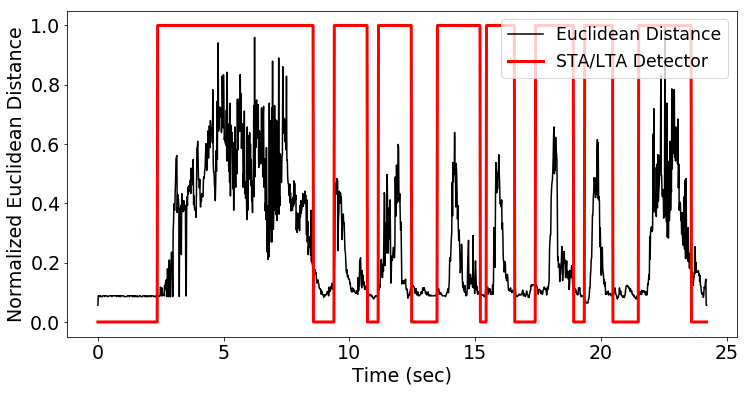

In [140]:
idx = 1
plt.plot(timevec,margin_tr[idx]/max(margin_tr[idx]),color='black')
plt.plot(timevec,mask_train[idx],linewidth=3,color='red')
plt.legend(['Euclidean Distance','STA/LTA Detector'], loc = 'upper right', fontsize = 'xx-large')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel('Time (sec)',fontsize=19, fontname='Comic Sans MS')
plt.ylabel('Normalized Euclidean Distance',fontsize=19)
# plt.savefig(str(idx)+' gesture detect.png',dpi=400)

In [141]:
def num_to_ch(num):
    label = ''
    for ch in num:
        label += chr(ord('@') + np.argmax(ch,-1)+1)
    return label

In [142]:
# convert detected labels
ctc_tr3 = [num_to_ch(y) for y in y3train]
ctc_ts3 = [num_to_ch(y) for y in y3test]

In [143]:
ctc_ts3

['AAAABBBBBBBBBBBBBBBB',
 'BBBBBBBCCCCCCCCCCCC',
 'NNNNNNN',
 'NNNNNAA',
 'AAOOOOOOOOOOOAAA',
 'APPPPPPPP',
 'AADDDDDDDDDDA',
 'AABBBBBBBBBBBBBBBBBBCCCCCCCCCCCCC',
 'KKKKKKKKK',
 'KKKKKAAA',
 'AAALLLLLLLLLLLLLAA',
 'AAMMMMMMM',
 'MMMMMAAA',
 'AADDDDDDDDAA',
 'AAAABBBBBBBBBBBBBBBBBB',
 'BBBBBBBBBBBCCCCCCCCCA',
 'AAAFFFFFFFFFFFFAAA',
 'AAGGGGGGGGGGGAAAAAA',
 'AADDDDDDDDD',
 'BBBBBBBBBBACCCCCCCCA',
 'AEEEEEEE',
 'AAAFFFFFFFFFFFFAA',
 'AAGGGGGGGGGGAAA',
 'AADDDDDDDDDDA',
 'AAAAABBBBBBBBBBBBBBBBBB',
 'BBBBBBBBBCCCCCCCCCCA',
 'NNNNNNNNNNNAA',
 'AAAOOOOOOOOOOOAA',
 'AAPPPPPPP',
 'PPPPAAA',
 'AADDDDDDDDD',
 'BBBBBBBBBBBBBBCCCCCCCCCCCCC',
 'HHHHAAA',
 'AAAIIIIIIIIIIIAAA',
 'AAJJJJJJJJJAA',
 'AADDDDDDDDDDA',
 'AABBBBBBBBBBBBBBBBBBBB',
 'BBBBBBBBBBBCCCCCCCCC',
 'AHHHHHHH',
 'AAAIIIIIIIIIIIAA',
 'AAJJJJJJJJJJAA',
 'AADDDDDDDDDA',
 'ABBBBBBBBBBB',
 'BBBBBBBBBBBBCCCCCCCCCCCCA',
 'AAEEEEEEEEEEA',
 'AAAFFFFFFFFFFAAA',
 'AAGGGGGGGGGGAA',
 'AADDDDDDDDDDA',
 'AAABBBBBBBBBBBBBBBBBBBBBBCCCCCCCCCC',
 'NNNNN

In [144]:
def data_generator_multi_nolabel_rd(data, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data[0].shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples1 = data[0][offset:offset+batch_size]
            batch_samples2 = data[1][offset:offset+batch_size]
            batch_samples3 = data[2][offset:offset+batch_size]
            
            # Initialise X_train and y_train arrays for this batch
            X_train1 = []
            X_train2 = []
            X_train3 = []
            # For each example
            for i in range(0,batch_samples1.shape[0]):
                X_train1.append(batch_samples1[i])
                X_train2.append(batch_samples2[i])
                X_train3.append(batch_samples3[i])
                
            # Make sure they're numpy arrays (as opposed to lists)
            X_train1 = np.array(X_train1)
            X_train2 = np.array(X_train2)
            X_train3 = np.array(X_train3)
            
            # yield the next training batch            
            yield [X_train1, X_train2, X_train3]

In [145]:
predict_generator = data_generator_multi_nolabel_rd([x1test, x2test, x3test])

In [146]:
fname = 'ctc aux multiinput multitask 92-03'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path
json_file = open(MODEL_FILE, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_load = model_from_json(loaded_model_json, {'CTCLayer': CTCLayer})
model_load.load_weights(WEIGHT_FILE)

In [147]:
prediction_model = keras.models.Model(
    [model_load.get_layer(name="rd").input, model_load.get_layer(name="ra").input, model_load.get_layer(name="image").input], model_load.get_layer(name="dense2").output
)

In [148]:
probs = np.array([np.squeeze(prediction_model.predict(next(predict_generator))) for i in range(len(x3test))],dtype=object)
pred = np.array([np.argmax(probs[i],-1) for i in range(len(x3test))], dtype = object)

In [149]:
pred_labels = []
pred_ch_ls = []
for p in pred:
    label = []
    for num in p:
        if num == 20:# or chr(ord('@')+num) == 'A':
            continue
        label.append(num)
    pred_labels.append(label)
pred_labels = np.array(pred_labels,dtype=object)  
print(pred_labels[3])

[8, 8, 1, 1, 1, 1, 1, 1]


In [150]:
for idx in range(len(y3test)):
    print(str(idx+1) + '. Predicted: ' + str(pred_labels[idx]) + ' | ' + str(np.argmax(y3test[idx],-1)) + ' :Original')

1. Predicted: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] | [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] :Original
2. Predicted: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2] | [1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2] :Original
3. Predicted: [7, 11, 7, 7, 1, 1, 1, 1, 1] | [13 13 13 13 13 13 13] :Original
4. Predicted: [8, 8, 1, 1, 1, 1, 1, 1] | [13 13 13 13 13  0  0] :Original
5. Predicted: [1, 1, 1, 1, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1, 1, 1, 1, 1, 1, 1] | [ 0  0 14 14 14 14 14 14 14 14 14 14 14  0  0  0] :Original
6. Predicted: [11, 11, 14, 14, 14, 1, 1, 1, 1, 1, 1] | [ 0 15 15 15 15 15 15 15 15] :Original
7. Predicted: [1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4] | [0 0 3 3 3 3 3 3 3 3 3 3 0] :Original
8. Predicted: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [151]:
from collections import Counter
mode_orig = [max(Counter(np.argmax(y,-1)+1)) for y in y3test]
mode_pred = [max(Counter(y)) if len(y) != 0 else 1 for y in pred_labels]

In [152]:
cmp = [mode_pred[i] == mode_orig[i] for i in range(len(y3test))]
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

60.30534351145038